# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 09.11.2023

Мягкий дедлайн: 22.11.2023

Жесткий дедлайн: 26.11.2023

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**: max - 1

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [244]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [245]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [246]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: Тут предсказывется не класс, а его вероятность

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [247]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


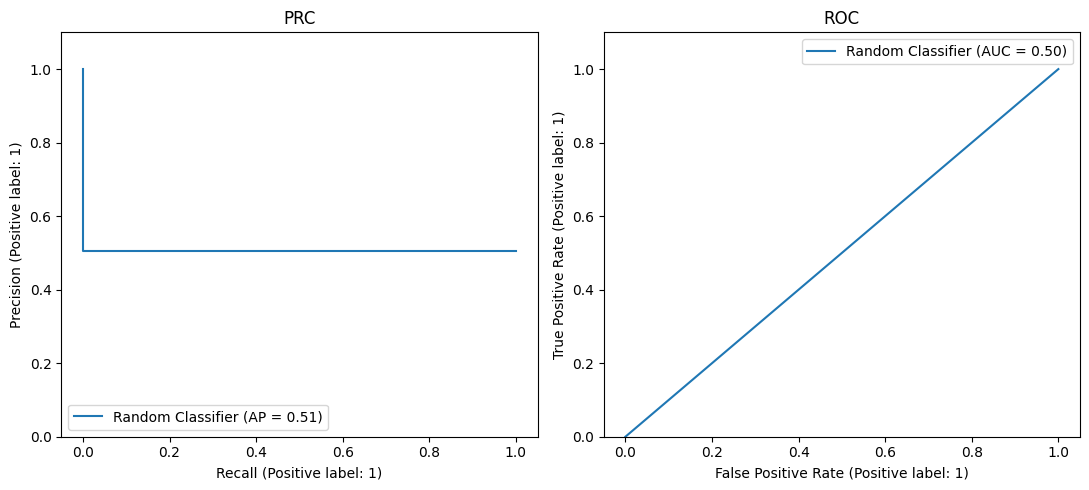

In [248]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
  if ax is None:
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))

  print(classifier_name, 'metrics')
  PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  print('AUC-PR: %.5f' % auc(recall, precision))
  ax[0].set_title("PRC")
  ax[0].set_ylim(0, 1.1)

  RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
  print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
  ax[1].set_title("ROC")
  ax[1].set_ylim(0, 1.1)

  plt.tight_layout()
  plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [249]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
precision, recall, _ = precision_recall_curve(y_test, y_random)
  # добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_random),
      0
]

  # по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`).

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [250]:
from sklearn.svm import LinearSVC
from tqdm import tqdm

In [251]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2, random_state=99)


In [252]:
c_vals = np.logspace(-5, 1, 10)
auc_vals = []

for c in tqdm(c_vals):
    model = LinearSVC(C=c).fit(X_train, y_train)
    res = model.predict(X_val)
    
    precision, recall, _ = precision_recall_curve(y_val, res)
    auc_vals.append(auc(recall, precision))
    

 70%|██████████████████████████████▊             | 7/10 [00:00<00:00, 56.37it/s]/Users/maximzabelin/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/maximzabelin/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/maximzabelin/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.34it/s]


In [253]:
final_c = c_vals[np.argmax(auc_vals)]
final_c

4.641588833612782e-05

  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

SVM metrics
AUC-PR: 0.83252
AUC-ROC: 0.84118


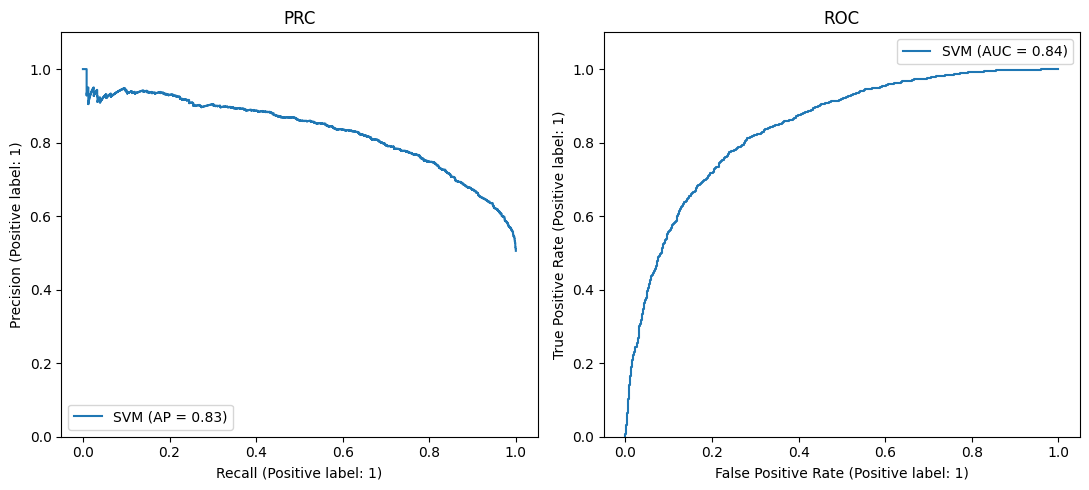

In [254]:
model =   LinearSVC(C=final_c).fit(X_train, y_train)
y_pred = model.predict(X_test)

y_res = model.decision_function(X_test)
y_res_n = (y_res - y_res.min())/(y_res.max() - y_res.min())


depict_pr_roc(y_test, y_res_n, 'SVM')

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [255]:
df_metrics.loc['SVC Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_res_n),
      final_c
]
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.50000,0.000000
SVC Classifier,0.824623,0.84118,0.000046


__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [256]:
from sklearn.linear_model import LogisticRegression

c_vals = np.logspace(-5, 1, 10)
auc_vals = []

for c in tqdm(c_vals):
    model = LogisticRegression(C=c).fit(X_train, y_train)
    res = model.predict(X_val)
    
    precision, recall, _ = precision_recall_curve(y_val, res)
    auc_vals.append(auc(recall, precision))
    

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 136.85it/s]


In [257]:
final_c = c_vals[np.argmax(auc_vals)]
final_c

0.021544346900318822

LR metrics
AUC-PR: 0.83254
AUC-ROC: 0.84688


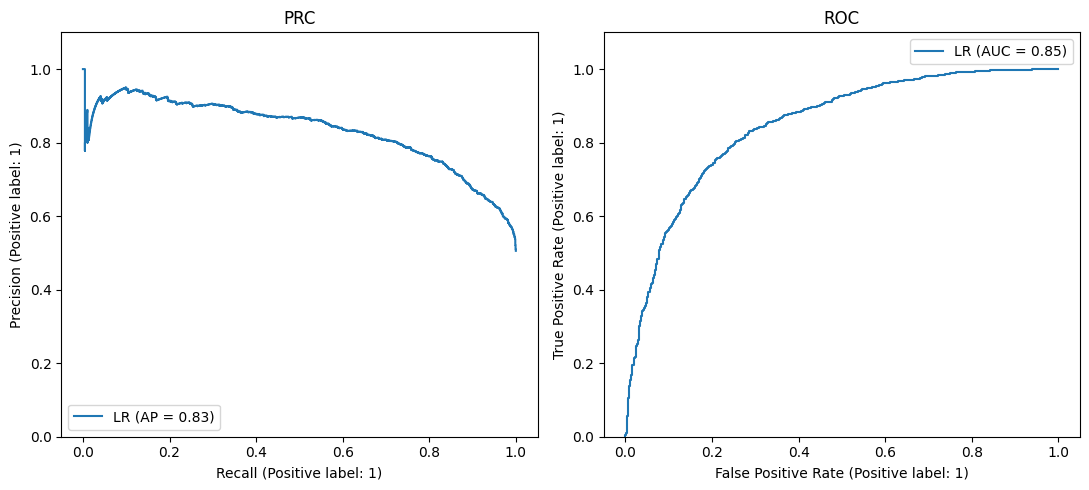

In [258]:
model = LogisticRegression(C=final_c).fit(X_train, y_train)
y_pred_lr = model.predict_proba(X_test)[:, 1]


depict_pr_roc(y_test, y_pred_lr, 'LR')

In [259]:
df_metrics.loc['LR Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_pred_lr),
      final_c
]
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.000000
SVC Classifier,0.824623,0.841180,0.000046
LR Classifier,0.829552,0.846879,0.021544


Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

Logistic Regression AUC-PR: 0.83254
Linear SVC AUC-PR: 0.83249
Linear SVC AUC-PR: 0.75283
Logistic Regression AUC-ROC: 0.84688
Linear SVC AUC-ROC: 0.84683
Linear SVC AUC-ROC: 0.50000


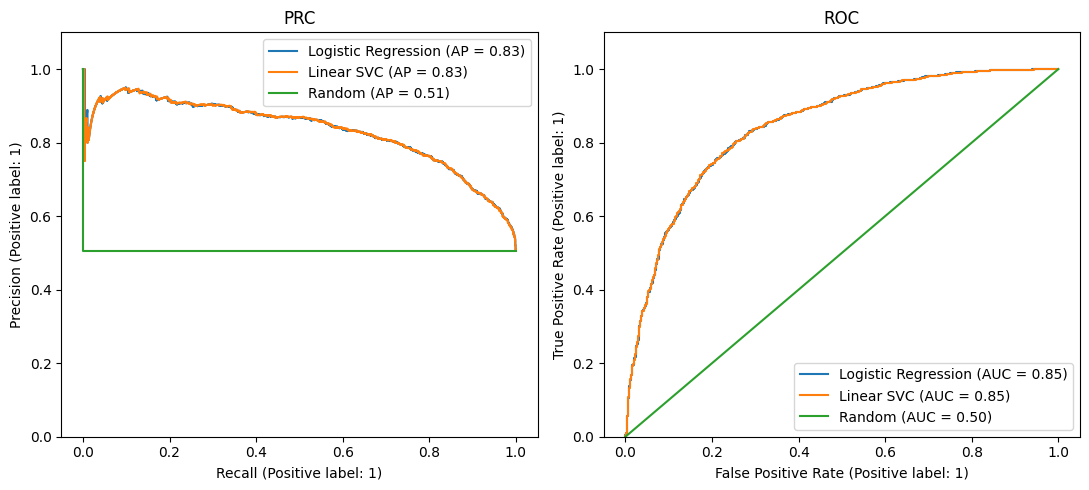

In [260]:

model1 = LogisticRegression(C=final_c).fit(X_train, y_train)
y_pred1 = model1.predict_proba(X_test)[:, 1]

model2 = LinearSVC(C=final_c).fit(X_train, y_train)
y_pred2 = model2.decision_function(X_test)


model_3 = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_pred3 = random_classifier.predict_proba(X_test)[:,1]


fig, ax = plt.subplots(1, 2, figsize=(11, 5))


PrecisionRecallDisplay.from_predictions(y_test, y_pred1, ax=ax[0], name='Logistic Regression')
precision1, recall1, _ = precision_recall_curve(y_test, y_pred1)
print('Logistic Regression AUC-PR: %.5f' % auc(recall1, precision1))

PrecisionRecallDisplay.from_predictions(y_test, y_pred2, ax=ax[0], name='Linear SVC')
precision2, recall2, _ = precision_recall_curve(y_test, y_pred2)
print('Linear SVC AUC-PR: %.5f' % auc(recall2, precision2))


# 
PrecisionRecallDisplay.from_predictions(y_test, y_pred3, ax=ax[0], name='Random')
precision3, recall3, _ = precision_recall_curve(y_test, y_pred3)
print('Linear SVC AUC-PR: %.5f' % auc(recall3, precision3))

ax[0].set_title("PRC")
ax[0].set_ylim(0, 1.1)
ax[0].legend()


RocCurveDisplay.from_predictions(y_test, y_pred1, ax=ax[1], name='Logistic Regression')
print('Logistic Regression AUC-ROC: %.5f' % roc_auc_score(y_test, y_pred1))

RocCurveDisplay.from_predictions(y_test, y_pred2, ax=ax[1], name='Linear SVC')
print('Linear SVC AUC-ROC: %.5f' % roc_auc_score(y_test, y_pred2))

# 
RocCurveDisplay.from_predictions(y_test, y_pred3, ax=ax[1], name='Random')
print('Linear SVC AUC-ROC: %.5f' % roc_auc_score(y_test, y_pred3))

ax[1].set_title("ROC")
ax[1].set_ylim(0, 1.1)
ax[1].legend()

plt.tight_layout()


**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** Разницы почти нет 

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

In [261]:
X, y = make_classification(
    n_samples=1000, n_features=2, n_informative=2, n_redundant=0, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [262]:
from sklearn.svm import SVC
model = SVC(kernel='linear', C=final_c).fit(X_train, y_train)

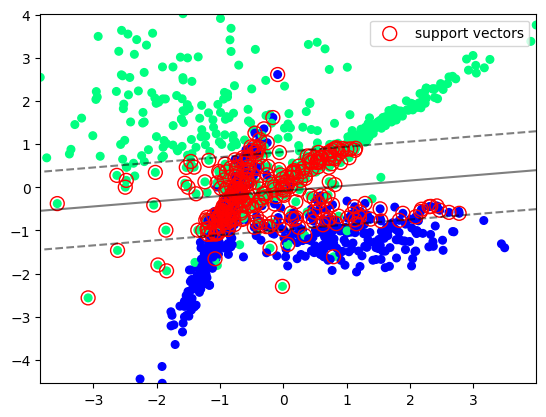

In [263]:
def plot_svm_2D(X, y, model,  plot_support=True):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(XX.shape)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])


    #Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='winter')

    #Отрисовали опорные векторы
    if plot_support:
        plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
                   label='support vectors',
                   s=100,
                   linewidth=1,
                   edgecolor="red",
                   facecolors='none')

    plt.legend()

plot_svm_2D(X, y, model)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** те которые в кружочках, они находятся ближе всего к границе

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [264]:
model = LogisticRegression(C=final_c).fit(X_train, y_train)

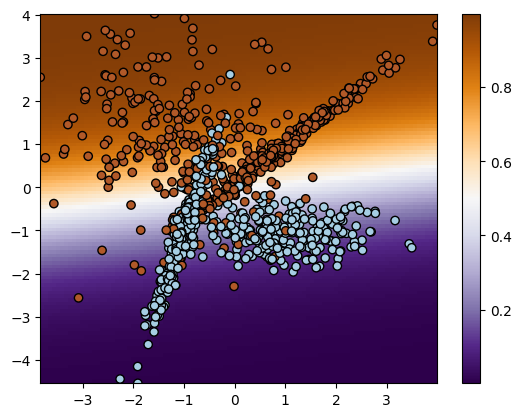

In [265]:
def plot_logreg_2D(X, y, model):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:, 1]
    Z = Z.reshape((xx.shape[0], -1)).T


    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)

    #Отрисовали выборку
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.Paired)

    plt.colorbar(image)


plot_logreg_2D(X, y, model)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** Это светлая область, где логарифм равен 0, а он равен нулю тк отношение классов 0.5 / 0.5 = 1 и log(1) = 0

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [266]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)]))
        
    plt.figure(figsize=(6,6))
    plt.plot([0, 1], [0, 1], label='real', linestyle=':', color='green')
    plt.plot(bin_middle_points, bin_real_ratios, label='model')
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [267]:
X, y = make_classification(n_samples=10_000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_calib, y_train, y_calib = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

Text(0.5, 1.0, 'LR')

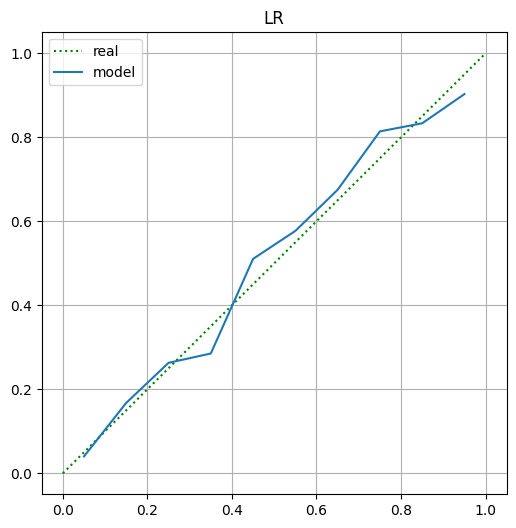

In [268]:
model = LogisticRegression(C=final_c).fit(X_train, y_train)
probs1 = model.predict_proba(X_test)[:, 1]
pred1 = model.decision_function(X_test)
plot_calibration_curve(y_test, probs1)
plt.legend()
plt.title('LR')

Text(0.5, 1.0, 'SVM')

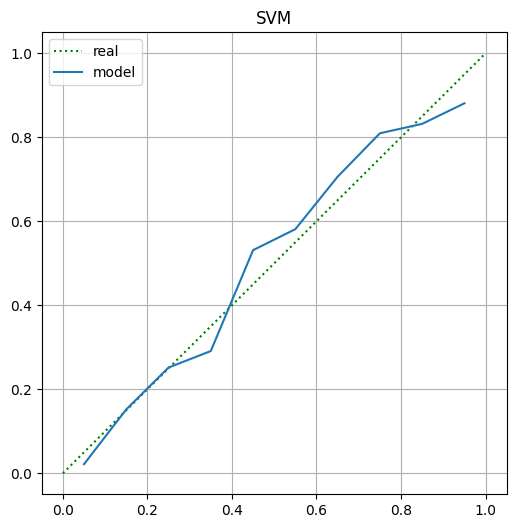

In [269]:
model = SVC(kernel='linear', C=final_c, probability=True).fit(X_train, y_train)
probs2 = model.predict_proba(X_test)[:, 1]
pred2 = model.decision_function(X_test)
plot_calibration_curve(y_test, probs2)
plt.legend()
plt.title('SVM')

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии?

**Ответ:** не плохо, но наверное можо и лучше

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

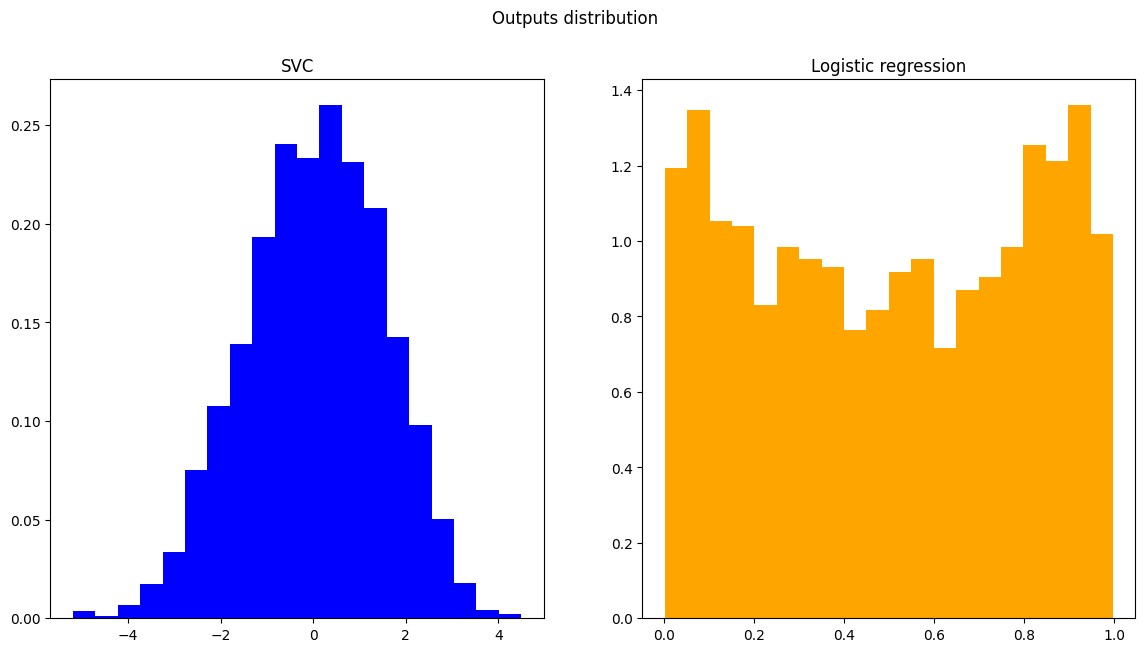

In [270]:
#your code here код с сема
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

axs[0].hist(pred2, bins=20, color='blue', density='True')
axs[1].hist(probs1, bins=20, color='orange', density='True')

axs[0].set_title('SVC')
axs[1].set_title('Logistic regression')

plt.suptitle('Outputs distribution')

plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** У логрега расределение похоже на равномерное, а у SVC на нормальное 

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

Text(0.5, 1.0, 'SVM colibrated')

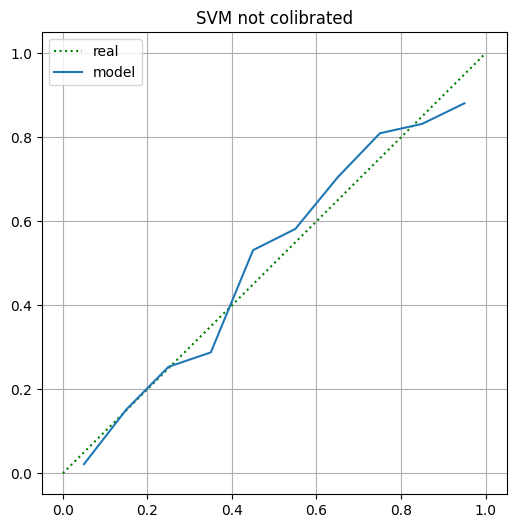

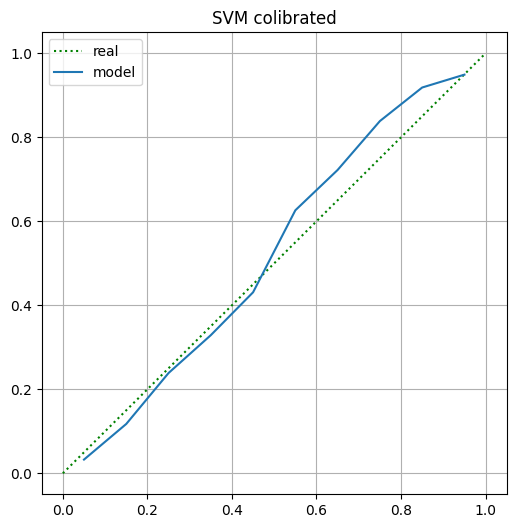

In [271]:
#your code here

from sklearn.calibration import CalibratedClassifierCV 
model = SVC(kernel='linear', C=final_c, probability=True).fit(X_train, y_train)
probs = model.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, probs)
plt.legend()
plt.title('SVM not colibrated')


model_colib = CalibratedClassifierCV(model, cv=5, method='sigmoid').fit(X_calib, y_calib)
probs_colib = model_colib.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, probs_colib)
plt.legend()
plt.title('SVM colibrated')

**Вопрос:** Улучшилась ли калибровочная кривая?

**Ответ:** ну кажется нет, примерно одно и тоже получилось

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [ ]:
#your code here

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [273]:
df = pd.read_csv('/Users/maximzabelin/Desktop/bike_buyers.csv')
df

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,Married,Female,40000.0,1.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,Europe,42.0,No
1,24107,Married,Male,30000.0,3.0,Partial College,Clerical,Yes,1.0,0-1 Miles,Europe,43.0,No
2,14177,Married,Male,80000.0,5.0,Partial College,Professional,No,2.0,2-5 Miles,Europe,60.0,No
3,24381,Single,NaN,70000.0,0.0,Bachelors,Professional,Yes,1.0,5-10 Miles,Pacific,41.0,Yes
4,25597,Single,Male,30000.0,0.0,Bachelors,Clerical,No,0.0,0-1 Miles,Europe,36.0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,23731,Married,Male,60000.0,2.0,High School,Professional,Yes,2.0,2-5 Miles,North America,54.0,Yes
996,28672,Single,Male,70000.0,4.0,Graduate Degree,Professional,Yes,0.0,2-5 Miles,North America,35.0,Yes
997,11809,Married,NaN,60000.0,2.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,North America,38.0,Yes
998,19664,Single,Male,100000.0,3.0,Bachelors,Management,No,3.0,1-2 Miles,North America,38.0,No


In [274]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                1000 non-null   int64  
 1   Marital Status    993 non-null    object 
 2   Gender            989 non-null    object 
 3   Income            994 non-null    float64
 4   Children          992 non-null    float64
 5   Education         1000 non-null   object 
 6   Occupation        1000 non-null   object 
 7   Home Owner        996 non-null    object 
 8   Cars              991 non-null    float64
 9   Commute Distance  1000 non-null   object 
 10  Region            1000 non-null   object 
 11  Age               992 non-null    float64
 12  Purchased Bike    1000 non-null   object 
dtypes: float64(4), int64(1), object(8)
memory usage: 101.7+ KB


In [275]:
df.isna().sum()

ID                   0
Marital Status       7
Gender              11
Income               6
Children             8
Education            0
Occupation           0
Home Owner           4
Cars                 9
Commute Distance     0
Region               0
Age                  8
Purchased Bike       0
dtype: int64

In [276]:
for el in df.columns:
    print(el)

ID
Marital Status
Gender
Income
Children
Education
Occupation
Home Owner
Cars
Commute Distance
Region
Age
Purchased Bike


In [277]:
X_numerical = ['ID', 
               'Children', 
               'Cars', 
               'Age', 
               'Income']
X_categorical = ['Marital Status', 
                 'Gender', 
                 'Education',
                 'Occupation',
                 'Home Owner', 
                 'Commute Distance', 
                 'Region']

In [278]:
df[X_numerical] = df[X_numerical].fillna(df[X_numerical].mean())

In [279]:
df[X_categorical] = df[X_categorical].fillna('undefined')

In [280]:
df.isna().sum()

ID                  0
Marital Status      0
Gender              0
Income              0
Children            0
Education           0
Occupation          0
Home Owner          0
Cars                0
Commute Distance    0
Region              0
Age                 0
Purchased Bike      0
dtype: int64

In [281]:
X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')

В начале поработаем только с категориальными признаками

In [282]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[X_categorical], y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [283]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import time

In [284]:
col_transformer = ColumnTransformer([('ore', OrdinalEncoder(), X_categorical)])

pipeline = Pipeline(steps=[('encoding', col_transformer), 
                           ('model', LogisticRegression(max_iter=1_000, random_state=42))])

st = time.time()

model = pipeline.fit(X_train, y_train)

et = time.time()
et - st 

0.010482072830200195

In [285]:
pred = model.predict(X_test)
precision2, recall2, _ = precision_recall_curve(y_test, pred)
print(' AUC-PR: %.5f' % auc(recall2, precision2))

 AUC-PR: 0.62616


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [286]:
col_transformer = ColumnTransformer([('ore', OneHotEncoder(), X_categorical)])

pipeline = Pipeline(steps=[('encoding', col_transformer), 
                           ('model', LogisticRegression(max_iter=1_000, random_state=42))])

st = time.time()

model = pipeline.fit(X_train, y_train)

et = time.time()
et - st 

0.02344799041748047

 AUC-PR: 0.70489


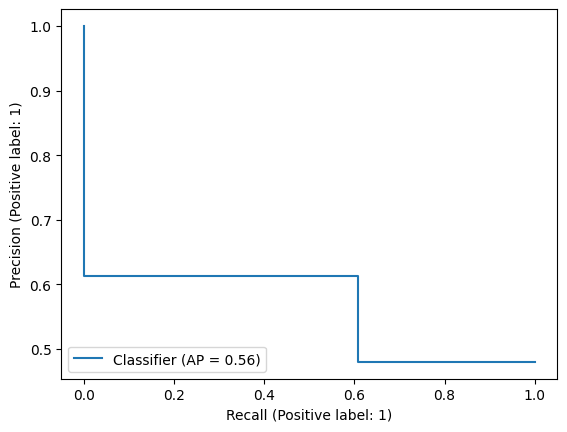

In [287]:
pred = model.predict(X_test)

PrecisionRecallDisplay.from_predictions(y_test, pred)
precision2, recall2, _ = precision_recall_curve(y_test, pred)
print(' AUC-PR: %.5f' % auc(recall2, precision2))

Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [288]:
#your code here
from sklearn.base import BaseEstimator, TransformerMixin

class MeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features):
        self.categorical_features = categorical_features
        self.mean_target_dict = {}

    def fit(self, X, y):
        for feature in self.categorical_features:
            feature_targets = pd.DataFrame({'feature': X[feature], 'target': y})
            mean_targets = feature_targets.groupby('feature')['target'].mean()
            self.mean_target_dict[feature] = mean_targets
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for feature in self.mean_target_dict:
            X_transformed[feature] = X_transformed[feature].map(self.mean_target_dict[feature])
        return X_transformed

In [289]:
col_transformer = ColumnTransformer([('ore', MeanTargetEncoder(X_categorical), X_categorical)])

pipeline = Pipeline(steps=[('encoding', col_transformer), 
                           ('model', LogisticRegression(max_iter=1_000, random_state=42))])

st = time.time()

model = pipeline.fit(X_train, y_train)

et = time.time()
et - st 

0.02439594268798828

In [291]:
pred = model.predict(X_test)
precision2, recall2, _ = precision_recall_curve(y_test, pred)
print(' AUC-PR: %.5f' % auc(recall2, precision2))

 AUC-PR: 0.67825


##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [ ]:
# сделал сразу хорошо

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [292]:
class MeanTargetEncoderWithNoise(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features, noise_level=0.01):
        self.categorical_features = categorical_features
        self.mean_target_dict = {}
        self.noise_level = noise_level

    def fit(self, X, y):
        for feature in self.categorical_features:
            feature_targets = pd.DataFrame({'feature': X[feature], 'target': y})
            mean_targets = feature_targets.groupby('feature')['target'].mean()
            self.mean_target_dict[feature] = mean_targets
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for feature in self.mean_target_dict:
            random_noise = np.random.normal(0, self.noise_level, size=len(X))
            X_transformed[feature] = X_transformed[feature].map(self.mean_target_dict[feature]) + random_noise
        return X_transformed

In [293]:
col_transformer = ColumnTransformer([('ore', MeanTargetEncoderWithNoise(X_categorical), X_categorical)])

pipeline = Pipeline(steps=[('encoding', col_transformer), 
                           ('model', LogisticRegression(max_iter=1_000, random_state=42))])

st = time.time()

model = pipeline.fit(X_train, y_train)

et = time.time()
et - st 

0.026144027709960938

In [294]:
pred = model.predict(X_test)
precision2, recall2, _ = precision_recall_curve(y_test, pred)
print(' AUC-PR: %.5f' % auc(recall2, precision2))

 AUC-PR: 0.69066


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** совмсем немного улучшилось 

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [ ]:
#your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [295]:
class MeanTargetEncoderWithSmoothing(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features, C=10):
        self.categorical_features = categorical_features
        self.mean_target_dict = {}
        self.global_mean = 0
        self.C = C

    def fit(self, X, y):
        self.global_mean = y.mean()
        for feature in self.categorical_features:
            feature_targets = pd.DataFrame({'feature': X[feature], 'target': y})
            mean_targets = (feature_targets.groupby('feature')['target'].sum() + self.C * self.global_mean) / \
                           (feature_targets.groupby('feature')['target'].count() + self.C)
            self.mean_target_dict[feature] = mean_targets
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for feature in self.mean_target_dict:
            X_transformed[feature] = X_transformed[feature].map(self.mean_target_dict[feature]).fillna(self.global_mean)
        return X_transformed



In [309]:
col_transformer = ColumnTransformer([('ore', MeanTargetEncoderWithSmoothing(X_categorical, C=500), X_categorical)])

pipeline = Pipeline(steps=[('encoding', col_transformer), 
                           ('model', LogisticRegression(max_iter=1_000, random_state=42))])

st = time.time()

model = pipeline.fit(X_train, y_train)

et = time.time()
print(f'time = {et - st}')

time = 0.02522110939025879


In [310]:
pred = model.predict(X_test)
precision2, recall2, _ = precision_recall_curve(y_test, pred)
print(' AUC-PR: %.5f' % auc(recall2, precision2))

 AUC-PR: 0.75733


Кажется использовать С=500 не то, что тут просили, но только так могу побить OHE

#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к признакам-счетчикам.


В данных есть пропуски - замените их средним значением признака



In [ ]:
#делал выше 

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?

In [311]:
#your code here

X_numerical = ['ID', 
               'Children', 
               'Cars', 
               'Age', 
               'Income'
              ]
X_categorical = ['Marital Status', 
                 'Gender', 
                 'Education',
                 'Occupation',
                 'Home Owner', 
                 'Commute Distance', 
                 'Region', 
                 'Children', 
                 'Cars', 
                 'Age', 
                 'Income']

X_train, X_test, y_train, y_test = train_test_split(df[X_categorical], y, test_size=0.25, random_state=777, stratify=y)

In [312]:
print('кодирую все сразу')

col_transformer = ColumnTransformer([('ore', MeanTargetEncoderWithSmoothing(X_categorical), X_categorical)])

pipeline = Pipeline(steps=[('encoding', col_transformer), 
                           ('model', LogisticRegression(max_iter=1_000, random_state=42))])

st = time.time()

model = pipeline.fit(X_train, y_train)

et = time.time()
print(f'time = {et - st}')

pred = model.predict(X_test)
precision2, recall2, _ = precision_recall_curve(y_test, pred)
print(' AUC-PR: %.5f' % auc(recall2, precision2))

кодирую все сразу
time = 0.03591585159301758
 AUC-PR: 0.70215


In [313]:
#your code here

X_numerical = ['ID', 
               'Children', 
               'Cars', 
               'Age', 
               'Income'
              ]
X_categorical = ['Marital Status', 
                 'Gender', 
                 'Education',
                 'Occupation',
                 'Home Owner', 
                 'Commute Distance', 
                 'Region', 
#                  'Children', 
#                  'Cars', 
                 'Age', 
                 'Income'
                ]

X_train, X_test, y_train, y_test = train_test_split(df[X_categorical], y, test_size=0.25, random_state=777, stratify=y)

In [314]:
print('кодирую все кроме children and cars')

col_transformer = ColumnTransformer([('ore', MeanTargetEncoderWithSmoothing(X_categorical), X_categorical)])

pipeline = Pipeline(steps=[('encoding', col_transformer), 
                           ('model', LogisticRegression(max_iter=1_000, random_state=42))])

st = time.time()

model = pipeline.fit(X_train, y_train)

et = time.time()
print(f'time = {et - st}')

pred = model.predict(X_test)
precision2, recall2, _ = precision_recall_curve(y_test, pred)
print(' AUC-PR: %.5f' % auc(recall2, precision2))

кодирую все кроме children and cars
time = 0.03374886512756348
 AUC-PR: 0.70583


In [315]:
#your code here

X_numerical = ['ID', 
               'Children', 
               'Cars', 
               'Age', 
               'Income'
              ]
X_categorical = ['Marital Status', 
                 'Gender', 
                 'Education',
                 'Occupation',
                 'Home Owner', 
                 'Commute Distance', 
                 'Region', 
                 'Children', 
                 'Cars', 
#                  'Age', 
#                  'Income'
                ]

X_train, X_test, y_train, y_test = train_test_split(df[X_categorical], y, test_size=0.25, random_state=777, stratify=y)

In [316]:
print('кодирую все кроме age and income')

col_transformer = ColumnTransformer([('ore', MeanTargetEncoderWithSmoothing(X_categorical), X_categorical)])

pipeline = Pipeline(steps=[('encoding', col_transformer), 
                           ('model', LogisticRegression(max_iter=1_000, random_state=42))])

st = time.time()

model = pipeline.fit(X_train, y_train)

et = time.time()
print(f'time = {et - st}')

pred = model.predict(X_test)
precision2, recall2, _ = precision_recall_curve(y_test, pred)
print(' AUC-PR: %.5f' % auc(recall2, precision2))

кодирую все кроме age and income
time = 0.036817312240600586
 AUC-PR: 0.72670


> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ ohe хоть и дает больше признаков, он легче, а с mte надо смотреть наилучший параметр и настраивать его, и можно наткнуться на переобучение 

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [149]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2023-11-22 00:05:10--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.data’

adult.data              [             <=>    ]   3,79M  1,45MB/s    in 2,6s    

2023-11-22 00:05:16 (1,45 MB/s) - ‘adult.data’ saved [3974305]



In [322]:
columns = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
16589,34,Private,271933,Masters,14,Never-married,Exec-managerial,Unmarried,White,Female,0,0,50,United-States,0


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`.

In [323]:
X_train, X_test, y_train, y_test = train_test_split(df, 
                                                    df['income'], 
                                                    test_size= 0.25, 
                                                    random_state=777, 
                                                    stratify=df['income'])

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [324]:
categorical = [ 'workclass', 
               'education',
               'marital-status',
               'occupation',
               'relationship', 
               'race', 
               'sex', 
               'native-country']

numeric = ['age', 
           'capital-gain', 
           'capital-loss', 
           'hours-per-week']

col_transformer = ColumnTransformer([('ohe', OneHotEncoder(), categorical)])

col_transformer.fit(X_train)

print(X_train.shape[1])
print(col_transformer.transform(X_train).shape[1])

15
102


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [325]:
from sklearn.preprocessing import StandardScaler

col_transformer = ColumnTransformer([('ohe', OneHotEncoder(), categorical),
                                     ('scale', StandardScaler(), numeric)])

pipeline = Pipeline(steps=[('encoding', col_transformer), 
                           ('model', LogisticRegression(max_iter=1_000, random_state=777))])

st = time.time()

model = pipeline.fit(X_train, y_train)

et = time.time()
print(f'time = {et - st}')

pred = model.predict_proba(X_test)[:, 1]
precision2, recall2, _ = precision_recall_curve(y_test, pred)
print(' AUC-PR: %.5f' % auc(recall2, precision2))

time = 0.4380030632019043
 AUC-PR: 0.76638


#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [326]:
from sklearn.feature_selection import SelectFromModel

col_transformer = ColumnTransformer([('ohe', OneHotEncoder(), categorical),
                                     ('scale', StandardScaler(), numeric)])

pipeline = Pipeline(steps=[('encoding', col_transformer), 
                           ('model', LogisticRegression(max_iter=1_000, random_state=777))])
st = time.time()
model = pipeline.fit(X_train, y_train)
et = time.time()
print(f'Initial training time = {et - st}')

pred = model.predict_proba(X_test)[:, 1]
precision2, recall2, _ = precision_recall_curve(y_test, pred)
print(' AUC-PR: %.5f' % auc(recall2, precision2))





coefs = pipeline.named_steps['model'].coef_[0]
idx = np.sort(np.abs(coefs))
param = idx[-40]

selector = SelectFromModel(model.named_steps['model'], threshold=param).fit(col_transformer.transform(X_train), y_train)

pipeline = Pipeline(steps=[('encoding', col_transformer), 
                           ('selector', selector),
                           ('model', LogisticRegression(max_iter=1_000, random_state=777))])
st = time.time()
model = pipeline.fit(X_train, y_train)
et = time.time()
print(f'Final training time = {et - st}')
pred = model.predict_proba(X_test)[:, 1]

precision2, recall2, _ = precision_recall_curve(y_test, pred)
print(' AUC-PR: %.5f' % auc(recall2, precision2))

Initial training time = 0.427645206451416
 AUC-PR: 0.76638
Final training time = 0.5675239562988281
 AUC-PR: 0.73367


Изменилось ли качество? Как?

упало, но не сильно 

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [327]:
col_transformer = ColumnTransformer([('ohe', OneHotEncoder(), categorical)])

pipeline = Pipeline(steps=[('encoding', col_transformer), 
                           ('model', LogisticRegression(max_iter=1_000, random_state=777))])
st = time.time()
model = pipeline.fit(X_train, y_train)
et = time.time()
print(f'Initial training time = {et - st}')

pred = model.predict_proba(X_test)[:, 1]
precision2, recall2, _ = precision_recall_curve(y_test, pred)
print(' AUC-PR: %.5f' % auc(recall2, precision2))





coefs = pipeline.named_steps['model'].coef_[0]
idx = np.sort(np.abs(coefs))
param = idx[-40]

selector = SelectFromModel(model.named_steps['model'], threshold=param).fit(col_transformer.transform(X_train), y_train)

pipeline = Pipeline(steps=[('encoding', col_transformer), 
                           ('selector', selector),
                           ('model', LogisticRegression(max_iter=1_000, random_state=777))])
st = time.time()
model = pipeline.fit(X_train, y_train)
et = time.time()
print(f'Final training time = {et - st}')
pred = model.predict_proba(X_test)[:, 1]

precision2, recall2, _ = precision_recall_curve(y_test, pred)
print(' AUC-PR: %.5f' % auc(recall2, precision2))

Initial training time = 0.27034902572631836
 AUC-PR: 0.68613
Final training time = 0.41793394088745117
 AUC-PR: 0.66876


Сильно просели в качестве и видно, что опять отбор бризнаков только мешает

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [333]:
#your code here


categorical_pipeline = Pipeline(steps=[
    ('ohe', OneHotEncoder()),
    ('scale', StandardScaler(with_mean=False))  
])


col_transformer = ColumnTransformer(transformers=[
    ('cat', categorical_pipeline, categorical),
    ('num', StandardScaler(), numeric)
])
pipeline = Pipeline(steps=[('encoding', col_transformer), 
                           ('model', LogisticRegression(max_iter=1_000, random_state=777))])
st = time.time()
model = pipeline.fit(X_train, y_train)
et = time.time()
print(f'Initial training time = {et - st}')

pred = model.predict_proba(X_test)[:, 1]
precision2, recall2, _ = precision_recall_curve(y_test, pred)
print(' AUC-PR: %.5f' % auc(recall2, precision2))





coefs = pipeline.named_steps['model'].coef_[0]
idx = np.sort(np.abs(coefs))
param = idx[-40]

selector = SelectFromModel(model.named_steps['model'], threshold=param).fit(col_transformer.transform(X_train), y_train)

pipeline = Pipeline(steps=[('encoding', col_transformer), 
                           ('selector', selector),
                           ('model', LogisticRegression(max_iter=1_000, random_state=777))])
st = time.time()
model = pipeline.fit(X_train, y_train)
et = time.time()
print(f'Final training time = {et - st}')
pred = model.predict_proba(X_test)[:, 1]

precision2, recall2, _ = precision_recall_curve(y_test, pred)
print(' AUC-PR: %.5f' % auc(recall2, precision2))

Initial training time = 0.238983154296875
 AUC-PR: 0.76521
Final training time = 0.4692988395690918
 AUC-PR: 0.75726


Масштабирование помогает, но все равно выкидывать признаки не лучшая идея 

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [343]:
# так задолбался через эти пайплайны делать, оттуда оч неудобно доставать данные 
# буду писать криво, но жить счастливо


ohe = OneHotEncoder(sparse_output=False)
scaler = StandardScaler()

ohe_apl = ohe.fit_transform(X_train[categorical])
cols = ohe.get_feature_names_out(input_features=categorical)
X_train_new = pd.DataFrame(scaler.fit_transform(ohe_apl), columns=cols)

ohe_apl = ohe.transform(X_test[categorical])
X_test_new = pd.DataFrame(scaler.transform(ohe_apl), columns=cols)

X_train_new.loc[:, numeric] = scaler.fit_transform(X_train[numeric])
X_test_new.loc[:, numeric] = scaler.transform(X_test[numeric])

In [344]:
X_train_new

,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 10th,education_ 11th,education_ 12th,education_ 1st-4th,education_ 5th-6th,education_ 7th-8th,education_ 9th,education_ Assoc-acdm,education_ Assoc-voc,education_ Bachelors,education_ Doctorate,education_ HS-grad,education_ Masters,education_ Preschool,education_ Prof-school,education_ Some-college,marital-status_ Divorced,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,occupation_ ?,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,...,race_ Other,race_ White,sex_ Female,sex_ Male,native-country_ ?,native-country_ Cambodia,native-country_ Canada,native-country_ China,native-country_ Columbia,native-country_ Cuba,native-country_ Dominican-Republic,native-country_ Ecuador,native-country_ El-Salvador,native-country_ England,native-country_ France,native-country_ Germany,native-country_ Greece,native-country_ Guatemala,native-country_ Haiti,native-country_ Holand-Netherlands,native-country_ Honduras,native-country_ Hong,native-country_ Hungary,native-country_ India,native-country_ Iran,native-country_ Ireland,native-country_ Italy,native-country_ Jamaica,native-country_ Japan,native-country_ Laos,native-country_ Mexico,native-country_ Nicaragua,native-country_ Outlying-US(Guam-USVI-etc),native-country_ Peru,native-country_ Philippines,native-country_ Poland,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,age,capital-gain,capital-loss,hours-per-week
0,-0.243229,-0.175045,-0.261767,-0.014311,-1.519963,-0.186872,-0.289801,4.864840,-0.02024,-0.172544,-0.192891,-0.114131,-0.072589,-0.102928,-0.145315,-0.126062,-0.180922,-0.206636,-0.441068,-0.115595,-0.692432,4.225771,-0.037885,-0.1353,-0.538974,-0.397981,-0.026394,1.082330,-0.114131,-0.698589,-0.181043,-0.174298,-0.243701,-0.360165,-0.015677,-0.381952,2.655954,-0.176407,-0.209635,-0.259077,-0.338241,-0.064445,-0.380543,-0.142797,-0.354847,-0.167314,-0.229119,-0.825512,-0.586997,-0.177146,...,-0.0911,0.411617,1.424966,-1.424966,-0.129210,-0.022173,-0.058399,-0.046195,-0.046638,-0.053617,-0.04837,-0.030029,-0.058045,-0.054757,-0.029338,-0.063151,-0.032647,-0.045747,-0.039478,-0.006399,-0.018103,-0.025605,-0.019201,-0.055132,-0.03734,-0.02716,-0.047077,-0.050042,-0.042967,-0.026394,-0.144874,-0.030704,-0.019201,-0.030029,-0.076478,-0.046195,-0.032647,-0.058045,-0.021229,-0.049213,-0.038954,-0.024792,-0.022173,0.339967,-0.045296,-0.023079,1.574178,0.263894,-0.217048,-0.039398
1,-0.243229,-0.175045,3.820192,-0.014311,-1.519963,-0.186872,-0.289801,-0.205557,-0.02024,-0.172544,-0.192891,-0.114131,-0.072589,-0.102928,-0.145315,-0.126062,-0.180922,-0.206636,-0.441068,-0.115595,-0.692432,-0.236643,-0.037885,-0.1353,1.855377,2.512681,-0.026394,-0.923932,-0.114131,-0.698589,-0.181043,-0.174298,-0.243701,-0.360165,-0.015677,-0.381952,2.655954,-0.176407,-0.209635,-0.259077,-0.338241,-0.064445,-0.380543,-0.142797,-0.354847,-0.167314,-0.229119,-0.825512,1.703586,-0.177146,...,-0.0911,0.411617,1.424966,-1.424966,-0.129210,-0.022173,-0.058399,-0.046195,-0.046638,-0.053617,-0.04837,-0.030029,-0.058045,-0.054757,-0.029338,-0.063151,-0.032647,-0.045747,-0.039478

In [346]:
dff = pd.concat([X_train_new, y_train], axis=1)
dff

,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 10th,education_ 11th,education_ 12th,education_ 1st-4th,education_ 5th-6th,education_ 7th-8th,education_ 9th,education_ Assoc-acdm,education_ Assoc-voc,education_ Bachelors,education_ Doctorate,education_ HS-grad,education_ Masters,education_ Preschool,education_ Prof-school,education_ Some-college,marital-status_ Divorced,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,occupation_ ?,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,...,race_ White,sex_ Female,sex_ Male,native-country_ ?,native-country_ Cambodia,native-country_ Canada,native-country_ China,native-country_ Columbia,native-country_ Cuba,native-country_ Dominican-Republic,native-country_ Ecuador,native-country_ El-Salvador,native-country_ England,native-country_ France,native-country_ Germany,native-country_ Greece,native-country_ Guatemala,native-country_ Haiti,native-country_ Holand-Netherlands,native-country_ Honduras,native-country_ Hong,native-country_ Hungary,native-country_ India,native-country_ Iran,native-country_ Ireland,native-country_ Italy,native-country_ Jamaica,native-country_ Japan,native-country_ Laos,native-country_ Mexico,native-country_ Nicaragua,native-country_ Outlying-US(Guam-USVI-etc),native-country_ Peru,native-country_ Philippines,native-country_ Poland,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,age,capital-gain,capital-loss,hours-per-week,income
0,-0.243229,-0.175045,-0.261767,-0.014311,-1.519963,-0.186872,-0.289801,4.864840,-0.02024,-0.172544,-0.192891,-0.114131,-0.072589,-0.102928,-0.145315,-0.126062,-0.180922,-0.206636,-0.441068,-0.115595,-0.692432,4.225771,-0.037885,-0.1353,-0.538974,-0.397981,-0.026394,1.082330,-0.114131,-0.698589,-0.181043,-0.174298,-0.243701,-0.360165,-0.015677,-0.381952,2.655954,-0.176407,-0.209635,-0.259077,-0.338241,-0.064445,-0.380543,-0.142797,-0.354847,-0.167314,-0.229119,-0.825512,-0.586997,-0.177146,...,0.411617,1.424966,-1.424966,-0.12921,-0.022173,-0.058399,-0.046195,-0.046638,-0.053617,-0.04837,-0.030029,-0.058045,-0.054757,-0.029338,-0.063151,-0.032647,-0.045747,-0.039478,-0.006399,-0.018103,-0.025605,-0.019201,-0.055132,-0.03734,-0.02716,-0.047077,-0.050042,-0.042967,-0.026394,-0.144874,-0.030704,-0.019201,-0.030029,-0.076478,-0.046195,-0.032647,-0.058045,-0.021229,-0.049213,-0.038954,-0.024792,-0.022173,0.339967,-0.045296,-0.023079,1.574178,0.263894,-0.217048,-0.039398,0.0
1,-0.243229,-0.175045,3.820192,-0.014311,-1.519963,-0.186872,-0.289801,-0.205557,-0.02024,-0.172544,-0.192891,-0.114131,-0.072589,-0.102928,-0.145315,-0.126062,-0.180922,-0.206636,-0.441068,-0.115595,-0.692432,-0.236643,-0.037885,-0.1353,1.855377,2.512681,-0.026394,-0.923932,-0.114131,-0.698589,-0.181043,-0.174298,-0.243701,-0.360165,-0.015677,-0.381952,2.655954,-0.176407,-0.209635,-0.259077,-0.338241,-0.064445,-0.380543,-0.142797,-0.354847,-0.167314,-0.229119,-0.825512,1.703586,-0.177146,...,0.411617,1.424966,-1.424966,-0.12921,-0.022173,-0.058399,-0.046195,-0.046638,-0.053617,-0.04837,-0.030029,-0.058045,-0.054757,-0.029338,-0.063151,-0.032647,-0.045747,-0.039478,-0.006399,-0.01810

In [349]:
pd.DataFrame(y_train)

,income
14004,1
21060,0
7926,0
11552,0
15648,0
...,...
18970,0
21382,0
10830,0
14560,1


In [355]:
gr = pd.concat([X_train_new, y_train], axis=1)\
.groupby(pd.DataFrame(y_train)\
.columns[0])
gr

In [358]:
stats = {}

for col in X_train_new.columns:
    means = gr[col].mean().reset_index()[col]
    mp = means.iloc[0]
    mm = means.iloc[1]    
    
    quantity = gr[col].count().reset_index()[col]
    qp = quantity.iloc[0]
    qm = quantity.iloc[1]
    
    disper = gr[col].var().reset_index()[col]
    dp = disper.iloc[0]
    dm = disper.iloc[1]
    
    stat = np.abs(mp - mm) / np.sqrt((qp*dp + qm * dm)/(qp + qm))
    stats[col] = stat
    
    


/var/folders/gj/cnptwztn46g1k55td3tlxp3m0000gn/T/ipykernel_78094/1224095279.py:16: RuntimeWarning: invalid value encountered in double_scalars
  stat = np.abs(mp - mm) / np.sqrt((qp*dp + qm * dm)/(qp + qm))


In [362]:
df_stat = pd.DataFrame(list(stats.items()), columns=['col', 'stat'])
df_stat

,col,stat
0,workclass_ ?,0.002468
1,workclass_ Federal-gov,0.009760
2,workclass_ Local-gov,0.015186
3,workclass_ Never-worked,0.000797
4,workclass_ Private,0.029280
...,...,...
101,native-country_ Yugoslavia,0.002179
102,age,0.023869
103,capital-gain,0.004749
104,capital-loss,0.025374


In [374]:
best_cols = df_stat.sort_values(by='stat', ascending=False)[:40].loc[:, 'col'].to_numpy()
best_cols

array(['occupation_ Handlers-cleaners',
       'marital-status_ Married-AF-spouse', 'workclass_ Without-pay',
       'native-country_ El-Salvador', 'workclass_ Self-emp-inc',
       'hours-per-week', 'workclass_ Private', 'native-country_ Italy',
       'capital-loss', 'education_ 11th', 'marital-status_ Widowed',
       'native-country_ Haiti', 'education_ Bachelors', 'age',
       'native-country_ Honduras', 'native-country_ Hungary',
       'native-country_ Greece', 'education_ 7th-8th',
       'occupation_ Exec-managerial', 'education_ 5th-6th',
       'occupation_ Adm-clerical', 'education_ Assoc-voc',
       'education_ Some-college', 'native-country_ Columbia',
       'native-country_ Nicaragua', 'race_ White',
       'native-country_ France', 'education_ 12th',
       'native-country_ Hong', 'native-country_ Ireland',
       'native-country_ Poland', 'marital-status_ Married-civ-spouse',
       'occupation_ Craft-repair', 'relationship_ Husband',
       'occupation_ Priv-house-

In [376]:
df_stat.sort_values(by='stat', ascending=False)

,col,stat
38,occupation_ Handlers-cleaners,0.044272
26,marital-status_ Married-AF-spouse,0.036397
8,workclass_ Without-pay,0.035492
68,native-country_ El-Salvador,0.034503
5,workclass_ Self-emp-inc,0.032864
...,...,...
3,workclass_ Never-worked,0.000797
6,workclass_ Self-emp-not-inc,0.000634
44,occupation_ Sales,0.000627
39,occupation_ Machine-op-inspct,0.000525


In [375]:
model = LogisticRegression()
model = model.fit(X_train_new[best_cols], y_train)
pred = model.predict_proba(X_test_new[best_cols])[:, 1]
precision2, recall2, _ = precision_recall_curve(y_test, pred)
print(' AUC-PR: %.5f' % auc(recall2, precision2))

 AUC-PR: 0.64876


In [ ]:
качество упало, а я столько возился с этим

#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [377]:
X_train, X_val, y_train, y_val = train_test_split(X_train_new,
                                                  y_train, 
                                                  test_size=0.2, 
                                                  stratify=y_train, 
                                                  random_state=777)

In [387]:
X_train = X_train.reset_index().drop(columns='index')
X_val = X_val.reset_index().drop(columns='index')
y_train = y_train.reset_index().drop(columns='index')
y_val = y_val.reset_index().drop(columns='index')

In [391]:
import warnings
warnings.filterwarnings('ignore')


In [395]:
from tqdm import tqdm

X_train_copy = X_train.copy()
X_val_copy = X_val.copy()

model = LogisticRegression()


for i in range(106 - 40):
    print(f'{i} / {max(range(106 - 40))}')
    loser = X_train_copy.columns[0]
    best_score = 0
    for col in tqdm(X_train_copy.columns):
        model = model.fit(X_train_copy.drop(columns=col), y_train)
        pred = model.predict(X_val_copy.drop(columns=col))
        
        
        precision2, recall2, _ = precision_recall_curve(y_val, pred)
        score = auc(recall2, precision2)
        if score > best_score:
            best_score = score
            loser = col
    
    X_train_copy = X_train_copy.drop(columns=loser)
    X_val_copy = X_val_copy.drop(columns=loser)
        

0 / 56


100%|█████████████████████████████████████████| 106/106 [00:17<00:00,  5.93it/s]


1 / 56


100%|█████████████████████████████████████████| 105/105 [00:20<00:00,  5.15it/s]


2 / 56


100%|█████████████████████████████████████████| 104/104 [00:21<00:00,  4.76it/s]


3 / 56


100%|█████████████████████████████████████████| 103/103 [00:21<00:00,  4.87it/s]


4 / 56


100%|█████████████████████████████████████████| 102/102 [00:22<00:00,  4.63it/s]


5 / 56


100%|█████████████████████████████████████████| 101/101 [00:20<00:00,  4.93it/s]


6 / 56


100%|█████████████████████████████████████████| 100/100 [00:20<00:00,  4.83it/s]


7 / 56


100%|███████████████████████████████████████████| 99/99 [00:19<00:00,  5.00it/s]


8 / 56


100%|███████████████████████████████████████████| 98/98 [00:18<00:00,  5.29it/s]


9 / 56


100%|███████████████████████████████████████████| 97/97 [00:17<00:00,  5.55it/s]


10 / 56


100%|███████████████████████████████████████████| 96/96 [00:19<00:00,  4.95it/s]


11 / 56


100%|███████████████████████████████████████████| 95/95 [00:19<00:00,  4.99it/s]


12 / 56


100%|███████████████████████████████████████████| 94/94 [00:18<00:00,  4.97it/s]


13 / 56


100%|███████████████████████████████████████████| 93/93 [00:17<00:00,  5.22it/s]


14 / 56


100%|███████████████████████████████████████████| 92/92 [00:18<00:00,  5.10it/s]


15 / 56


100%|███████████████████████████████████████████| 91/91 [00:17<00:00,  5.27it/s]


16 / 56


100%|███████████████████████████████████████████| 90/90 [00:17<00:00,  5.15it/s]


17 / 56


100%|███████████████████████████████████████████| 89/89 [00:16<00:00,  5.54it/s]


18 / 56


100%|███████████████████████████████████████████| 88/88 [00:16<00:00,  5.22it/s]


19 / 56


100%|███████████████████████████████████████████| 87/87 [00:16<00:00,  5.28it/s]


20 / 56


100%|███████████████████████████████████████████| 86/86 [00:15<00:00,  5.68it/s]


21 / 56


100%|███████████████████████████████████████████| 85/85 [00:15<00:00,  5.52it/s]


22 / 56


100%|███████████████████████████████████████████| 84/84 [00:12<00:00,  6.51it/s]


23 / 56


100%|███████████████████████████████████████████| 83/83 [00:12<00:00,  6.61it/s]


24 / 56


100%|███████████████████████████████████████████| 82/82 [00:07<00:00, 10.81it/s]


25 / 56


100%|███████████████████████████████████████████| 81/81 [00:07<00:00, 11.25it/s]


26 / 56


100%|███████████████████████████████████████████| 80/80 [00:08<00:00,  9.26it/s]


27 / 56


100%|███████████████████████████████████████████| 79/79 [00:08<00:00,  9.29it/s]


28 / 56


100%|███████████████████████████████████████████| 78/78 [00:08<00:00,  9.10it/s]


29 / 56


100%|███████████████████████████████████████████| 77/77 [00:07<00:00,  9.87it/s]


30 / 56


100%|███████████████████████████████████████████| 76/76 [00:07<00:00,  9.70it/s]


31 / 56


100%|███████████████████████████████████████████| 75/75 [00:08<00:00,  8.85it/s]


32 / 56


100%|███████████████████████████████████████████| 74/74 [00:08<00:00,  9.17it/s]


33 / 56


100%|███████████████████████████████████████████| 73/73 [00:07<00:00, 10.29it/s]


34 / 56


100%|███████████████████████████████████████████| 72/72 [00:07<00:00, 10.16it/s]


35 / 56


100%|███████████████████████████████████████████| 71/71 [00:07<00:00,  9.53it/s]


36 / 56


100%|███████████████████████████████████████████| 70/70 [00:06<00:00, 11.39it/s]


37 / 56


100%|███████████████████████████████████████████| 69/69 [00:05<00:00, 11.75it/s]


38 / 56


100%|███████████████████████████████████████████| 68/68 [00:05<00:00, 11.65it/s]


39 / 56


100%|███████████████████████████████████████████| 67/67 [00:05<00:00, 11.67it/s]


40 / 56


100%|███████████████████████████████████████████| 66/66 [00:05<00:00, 11.41it/s]


41 / 56


100%|███████████████████████████████████████████| 65/65 [00:05<00:00, 12.96it/s]


42 / 56


100%|███████████████████████████████████████████| 64/64 [00:05<00:00, 10.83it/s]


43 / 56


100%|███████████████████████████████████████████| 63/63 [00:05<00:00, 11.53it/s]


44 / 56


100%|███████████████████████████████████████████| 62/62 [00:05<00:00, 11.87it/s]


45 / 56


100%|███████████████████████████████████████████| 61/61 [00:04<00:00, 12.69it/s]


46 / 56


100%|███████████████████████████████████████████| 60/60 [00:04<00:00, 12.10it/s]


47 / 56


100%|███████████████████████████████████████████| 59/59 [00:04<00:00, 13.67it/s]


48 / 56


100%|███████████████████████████████████████████| 58/58 [00:04<00:00, 13.36it/s]


49 / 56


100%|███████████████████████████████████████████| 57/57 [00:04<00:00, 13.48it/s]


50 / 56


100%|███████████████████████████████████████████| 56/56 [00:04<00:00, 12.66it/s]


51 / 56


100%|███████████████████████████████████████████| 55/55 [00:03<00:00, 13.94it/s]


52 / 56


100%|███████████████████████████████████████████| 54/54 [00:04<00:00, 13.12it/s]


53 / 56


100%|███████████████████████████████████████████| 53/53 [00:03<00:00, 14.33it/s]


54 / 56


100%|███████████████████████████████████████████| 52/52 [00:03<00:00, 13.36it/s]


55 / 56


100%|███████████████████████████████████████████| 51/51 [00:03<00:00, 14.26it/s]


56 / 56


100%|███████████████████████████████████████████| 50/50 [00:03<00:00, 14.54it/s]


57 / 56


100%|███████████████████████████████████████████| 49/49 [00:03<00:00, 15.39it/s]


58 / 56


100%|███████████████████████████████████████████| 48/48 [00:03<00:00, 13.81it/s]


59 / 56


100%|███████████████████████████████████████████| 47/47 [00:02<00:00, 16.45it/s]


60 / 56


100%|███████████████████████████████████████████| 46/46 [00:02<00:00, 16.05it/s]


61 / 56


100%|███████████████████████████████████████████| 45/45 [00:02<00:00, 16.52it/s]


62 / 56


100%|███████████████████████████████████████████| 44/44 [00:02<00:00, 16.57it/s]


63 / 56


100%|███████████████████████████████████████████| 43/43 [00:02<00:00, 17.95it/s]


64 / 56


100%|███████████████████████████████████████████| 42/42 [00:02<00:00, 16.45it/s]


65 / 56


100%|███████████████████████████████████████████| 41/41 [00:02<00:00, 17.66it/s]


ахах 65 из почему-то 56 итераций

In [398]:
model = LogisticRegression()
model = model.fit(X_train_copy, y_train)
pred = model.predict(X_val_copy)
precision2, recall2, _ = precision_recall_curve(y_val, pred)
auc(recall2, precision2)


0.7274510043497384

тут уже получилось улучшить качество

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [399]:
from IPython.display import clear_output


In [402]:
X_train_coll = pd.DataFrame()
X_val_coll = pd.DataFrame()

X_train_pass = pd.DataFrame()
X_val_pass = pd.DataFrame()

model = LogisticRegression()

all_columns = list(X_train.columns)

for i in range(40):
    clear_output(wait=False)
    print(f'{i} / 40')
    
    best_score = 0
    col_to_add = X_train.columns[0]
    
    for col in tqdm(all_columns):
        X_train_pass = X_train_coll
        X_val_pass = X_val_coll
        
        X_train_pass[col] = X_train[col]
        X_val_pass[col] = X_val[col]
        
        model = model.fit(X_train_pass, y_train)
        pred = model.predict(X_val_pass)
        
        precision2, recall2, _ = precision_recall_curve(y_val, pred)
        score = auc(recall2, precision2)
        
        if score > best_score:
            best_score = score
            col_to_add = col
            
    X_train_coll[col_to_add] = X_train[col_to_add]
    X_val_coll[col_to_add] = X_val[col_to_add]
    all_columns.remove(col_to_add)
    
                    
        

39 / 40


100%|███████████████████████████████████████████| 67/67 [00:11<00:00,  5.83it/s]


In [414]:
model = LogisticRegression()
model = model.fit(X_train_coll, y_train)
pred = model.predict_proba(X_val_coll)[:, 1]
precision2, recall2, _ = precision_recall_curve(y_val, pred)
auc(recall2, precision2)


0.7720933519555386

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:**

Выбирать по весам -  не очень, как и со статистикой 

Жадный алгоритм - тоже плохо и  оооочень долго

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [404]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2023-11-23 19:19:13--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank-additional.zip’

bank-additional.zip     [      <=>           ] 434,15K   312KB/s    in 1,4s    

2023-11-23 19:19:17 (312 KB/s) - ‘bank-additional.zip’ saved [444572]

Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/._bank-additional  


In [405]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [406]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

In [409]:
for el in X.columns:
    print(f"'{el}', ")

'age', 
'job', 
'marital', 
'education', 
'default', 
'housing', 
'loan', 
'contact', 
'month', 
'day_of_week', 
'campaign', 
'pdays', 
'previous', 
'poutcome', 
'emp.var.rate', 
'cons.price.idx', 
'cons.conf.idx', 
'euribor3m', 
'nr.employed', 


В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [411]:
categorical = ['job', 
'marital', 
'education', 
'default', 
'housing', 
'loan', 
'contact', 
'month', 
'day_of_week', 
'poutcome']


numeric = ['age', 
'campaign', 
'pdays', 
'previous', 'emp.var.rate', 
'cons.price.idx', 
'cons.conf.idx', 
'euribor3m', 
'nr.employed']

In [413]:
from sklearn.model_selection import KFold, cross_val_score

col_transformer = ColumnTransformer([('ohe', OneHotEncoder(), categorical),
                                     ('scal', StandardScaler(), numeric)])

pipeline = Pipeline(steps = [('col_transformer', col_transformer), 
                             ('model', LogisticRegression())])
folds = KFold(n_splits=5, shuffle=True, random_state=500)

cross_val_score(pipeline, X, y, cv=folds)

array([0.90373877, 0.89973294, 0.89694101, 0.90724778, 0.89097973])

In [431]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, precision_recall_curve, auc

def pr_auc_scorer(model, X, y):
    y_pred_prob = model.predict_proba(X)[:, 1]
    precision, recall, _ = precision_recall_curve(y, y_pred_prob)
    return auc(recall, precision)

pr_auc_custom_scorer = make_scorer(pr_auc_scorer, needs_proba=True)

col_transformer = ColumnTransformer([('ohe', OneHotEncoder(), categorical),
                                     ('scal', StandardScaler(), numeric)])

pipeline = Pipeline(steps = [('col_transformer', col_transformer), 
                             ('model', LogisticRegression())])

folds = KFold(n_splits=5, shuffle=True, random_state=500)

cross_val_score(pipeline, X, y, cv=folds, scoring=pr_auc_custom_scorer)


array([nan, nan, nan, nan, nan])

In [422]:
folds = KFold(n_splits=5, shuffle=True, random_state=500)

col_transformer = ColumnTransformer([('ohe', OneHotEncoder(), categorical),
                                     ('scal', StandardScaler(), numeric)])

pipeline = Pipeline(steps = [('col_transformer', col_transformer), 
                             ('model', LogisticRegression())])

for train, val in folds.split(X):
    x_train = X.iloc[train]
    x_val = X.iloc[val]
    
    y_train = y.iloc[train]
    y_val = y.iloc[val]
    
    model = pipeline.fit(x_train, y_train)
    pred = model.predict_proba(x_val)[:, 1]
    precision2, recall2, _ = precision_recall_curve(y_val, pred)
    print(auc(recall2, precision2))
    

0.4804443515026522
0.43802358902071903
0.4498747715012344
0.46025139312235447
0.43102365900830836


Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [ ]:
# сделал выше

Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [435]:
# your code here

incomes = []
calls = []


folds = KFold(n_splits=5, shuffle=True, random_state=500)

col_transformer = ColumnTransformer([('ohe', OneHotEncoder(), categorical),
                                     ('scal', StandardScaler(), numeric)])

pipeline = Pipeline(steps = [('col_transformer', col_transformer), 
                             ('model', LogisticRegression())])

for train, val in folds.split(X):
    x_train = X.iloc[train]
    x_val = X.iloc[val]
    
    y_train = y.iloc[train]
    y_val = y.iloc[val]
    
    model = pipeline.fit(x_train, y_train)
    pred = model.predict(x_val)
    
    inc = 10 * (pred & y_val).sum()
    
    incomes.append(inc)
    calls.append(pred.sum())
    

In [436]:
incomes, calls

([2240, 2110, 2080, 2240, 1970], [309, 330, 328, 330, 321])

In [438]:
print(f'mean revenue {np.mean(incomes)}')
print(f'std revenue {np.std(incomes)}')
print(f'mean pay {np.mean(calls)}')
print(f'mean income {np.mean(incomes) - np.mean(calls)}')

mean revenue 2128.0
std revenue 102.64501936285072
mean pay 323.6
mean income 1804.4


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [439]:
#your code here

incomes = []
calls = []


folds = KFold(n_splits=5, shuffle=True, random_state=500)

col_transformer = ColumnTransformer([('ohe', OneHotEncoder(), categorical),
                                     ('scal', StandardScaler(), numeric)])

pipeline = Pipeline(steps = [('col_transformer', col_transformer), 
                             ('model', LogisticRegression())])

for train, val in folds.split(X):
    x_train = X.iloc[train]
    x_val = X.iloc[val]
    
    y_train = y.iloc[train]
    y_val = y.iloc[val]
    
    model = pipeline.fit(x_train, y_train)
    pred = model.predict(x_val)
    
    inc = np.random.uniform(0, 20) * (pred & y_val).sum()
    
    incomes.append(inc)
    calls.append(pred.sum())

In [440]:
incomes, calls

([4403.503115818766,
  1852.8125357434049,
  1396.3429087312504,
  4429.039808912519,
  127.58993031312984],
 [309, 330, 328, 330, 321])

In [441]:
print(f'mean revenue {np.mean(incomes)}')
print(f'std revenue {np.std(incomes)}')
print(f'mean pay {np.mean(calls)}')
print(f'mean income {np.mean(incomes) - np.mean(calls)}')

mean revenue 2441.8576599038142
std revenue 1708.3826366181572
mean pay 323.6
mean income 2118.2576599038143


огромная дисперсия, но и зарабатываем больше

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

100%|███████████████████████████████████████████| 10/10 [00:14<00:00,  1.49s/it]


10.0


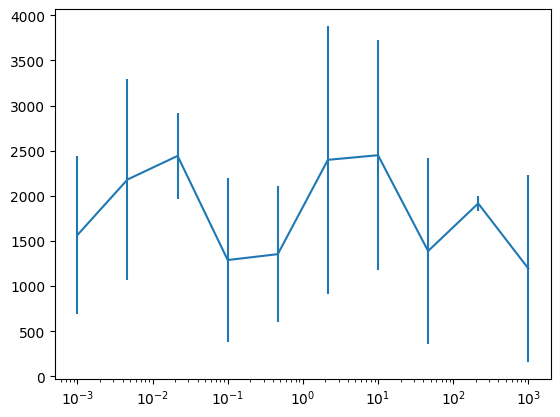

In [448]:
#your code here

def run_cv():

    col_transformer = ColumnTransformer([('ohe', OneHotEncoder(), categorical),
                                         ('scal', StandardScaler(), numeric)])

    folds = KFold(n_splits=5, shuffle=True, random_state=500)

    C_vals = np.logspace(-3, 3, 10)

    diffs = []
    std = []

    for c in tqdm(C_vals):

        pipeline = Pipeline(steps = [('col_transformer', col_transformer), 
                                     ('model', LogisticRegression(C=c))])
        fold_incomes = []
        fold_pays = []
        for train, val in folds.split(X):
            x_train = X.iloc[train]
            x_val = X.iloc[val]

            y_train = y.iloc[train]
            y_val = y.iloc[val]

            model = pipeline.fit(x_train, y_train)
            pred = model.predict(x_val)

            f_income = np.random.uniform(0, 20) * (pred & y_val).sum()
            f_calls = pred.sum()

            fold_incomes.append(f_income)
            fold_pays.append(f_calls)


        diffs.append(np.mean(fold_incomes) - np.mean(fold_pays))
        std.append(np.std(fold_incomes))

    plt.errorbar(C_vals, diffs, std)
    plt.xscale('log')
    print(C_vals[np.argmax(diffs)])
run_cv()

In [450]:
ничего лучше мы не получаем, дисперсия скачет также

SyntaxError: invalid syntax (392567112.py, line 1)

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

100%|███████████████████████████████████████████| 10/10 [00:14<00:00,  1.49s/it]


46.41588833612773


100%|███████████████████████████████████████████| 10/10 [00:15<00:00,  1.60s/it]


0.46415888336127775


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


0.021544346900318832


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


215.44346900318823


100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.73s/it]


0.004641588833612777


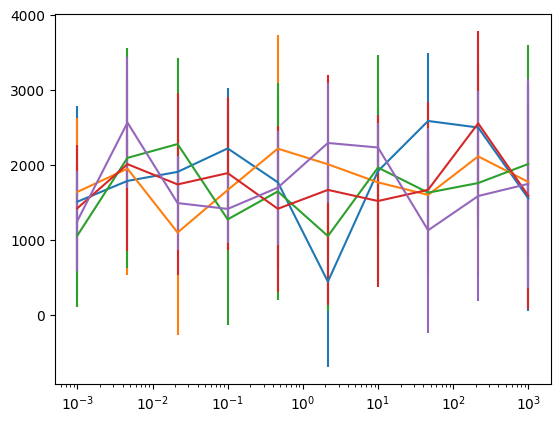

In [449]:
#your code here

for i in range(5):
    run_cv()

закономерномстей нет 

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ думаю, что recall тк в среднем мы тратим на клиентав меньше чем зарабатываем с него и лучше уж стараться ловить всех потенциальных клиентов



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [457]:
#your code here

col_transformer = ColumnTransformer([('ohe', OneHotEncoder(), categorical),
                                     ('scal', StandardScaler(), numeric)])

pipeline = Pipeline(steps = [('col_transformer', col_transformer), 
                             ('model', LogisticRegression())])

folds = KFold(n_splits=5, shuffle=True, random_state=500)

params = np.linspace(0, 1, 100)

incomes = []
diffs = []
std = []
for p in tqdm(params):
    fold_incomes = []
    fold_diff = []
    
    for train, val in folds.split(X):
        x_train = X.iloc[train]
        x_val = X.iloc[val]

        y_train = y.iloc[train]
        y_val = y.iloc[val]

        model = pipeline.fit(x_train, y_train)
        pred = np.where(model.predict_proba(x_val)[:, 1] > p, 1, 0)
        
        f_income = np.random.uniform(0, 20) * (pred & y_val).sum()
        f_calls = pred.sum()

        fold_incomes.append(f_income)
        fold_pays.append(f_calls)
    
    incomes.append(np.mean(fold_incomes))
    diffs.append(np.mean(fold_incomes) - np.mean(fold_pays))
    std.append(np.std(fold_incomes))
    

100%|█████████████████████████████████████████| 100/100 [02:59<00:00,  1.79s/it]


Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.




Text(0, 0.5, 'errors')

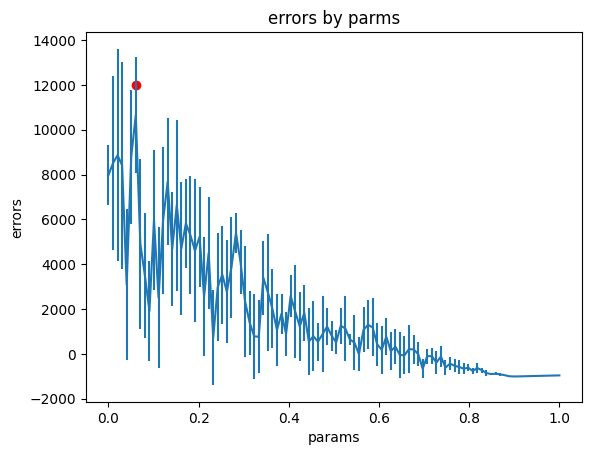

In [463]:
plt.errorbar(params, diffs, std)
plt.scatter(params[np.argmax(incomes)], max(incomes), c='red')
plt.title('errors by parms')
plt.xlabel('params')
plt.ylabel('errors')

In [465]:
bp = params[np.argmax(incomes)]
bp

0.06060606060606061

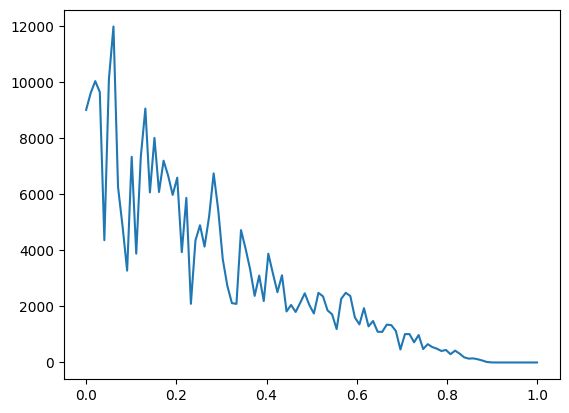

In [464]:
plt.plot(params, incomes)

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ наверное стоит брать не очень болбшой порог (0.15), при нем мы и не будем обзаванивать всех подряд, но и не упустим большинство людей которые могут приносить прибыль 

хоть аналитисески порог получился 0.5, там один пик и много пропастей, куда можно упасть и по графику видно, что 0.15 лучше подходит 

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [466]:
from sklearn.metrics import precision_score, recall_score

In [480]:
precisions = []
recalls = []

col_transformer = ColumnTransformer([('ohe', OneHotEncoder(), categorical),
                                     ('scal', StandardScaler(), numeric)])

pipeline = Pipeline(steps = [('col_transformer', col_transformer), 
                             ('model', LogisticRegression())])

folds = KFold(n_splits=5, shuffle=True, random_state=500)

for train, val in folds.split(X):
    x_train = X.iloc[train]
    x_val = X.iloc[val]

    y_train = y.iloc[train]
    y_val = y.iloc[val]

    model = pipeline.fit(x_train, y_train)
    pred = np.where(model.predict_proba(x_val)[:, 1] > 0.15, 1, 0)

    fold_pr = precision_score(y_val, pred)
    fold_rc = recall_score(y_val, pred)
    
    precisions.append(fold_pr)
    recalls.append(fold_rc)    
    
print(f'precision : mean  = {np.mean(precisions)} std = {np.std(precisions)}')
print(f'recall : mean  = {np.mean(recalls)} std = {np.std(recalls)}')

precision : mean  = 0.39037154629610565 std = 0.014629602844325608
recall : mean  = 0.6006471065557554 std = 0.020416990794700683


Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

In [481]:
recalls

[0.5815450643776824,
 0.5762527233115469,
 0.6211312700106724,
 0.626984126984127,
 0.5973223480947477]

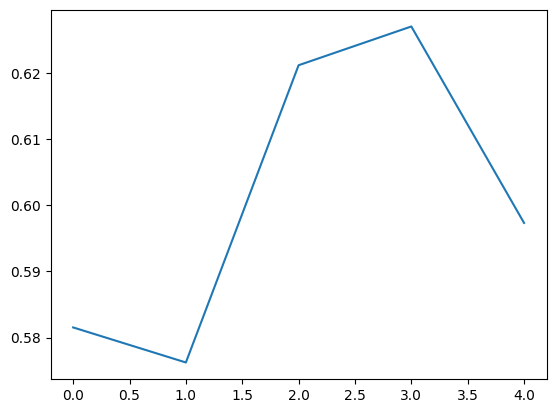

In [482]:
plt.plot(recalls)

In [483]:
#your code here


col_transformer = ColumnTransformer([('ohe', OneHotEncoder(), categorical),
                                     ('scal', StandardScaler(), numeric)])

pipeline = Pipeline(steps = [('col_transformer', col_transformer), 
                             ('model', LogisticRegression())])

folds = KFold(n_splits=5, shuffle=True, random_state=500)

params = np.linspace(0, 1, 100)

recalls = []
for p in tqdm(params):
    fold_recalls= []
    
    for train, val in folds.split(X):
        x_train = X.iloc[train]
        x_val = X.iloc[val]

        y_train = y.iloc[train]
        y_val = y.iloc[val]

        model = pipeline.fit(x_train, y_train)
        pred = np.where(model.predict_proba(x_val)[:, 1] > p, 1, 0)
        
        fold_rc = recall_score(y_val, pred)
        fold_recalls.append(fold_rc)
        
    recalls.append(np.mean(fold_recalls))

100%|█████████████████████████████████████████| 100/100 [02:56<00:00,  1.76s/it]


In [502]:
k = max(params[np.array(recalls) > 0.5])
k

0.24242424242424243

Text(0.5, 0, 'params')

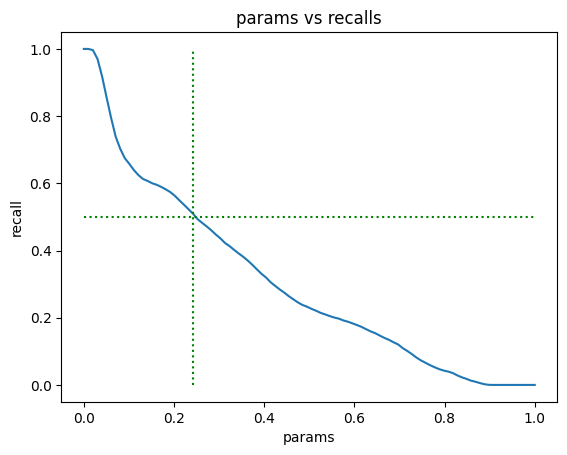

In [501]:
plt.plot(params, recalls)
plt.plot([0, 1], [0.5, 0.5], label='real', linestyle=':', color='green')
plt.plot([k, k], [0, 1], label='real', linestyle=':', color='green')
plt.title('params vs recalls')
plt.ylabel('recall')
plt.xlabel('params')

In [503]:
col_transformer = ColumnTransformer([('ohe', OneHotEncoder(), categorical),
                                     ('scal', StandardScaler(), numeric)])

pipeline = Pipeline(steps = [('col_transformer', col_transformer), 
                             ('model', LogisticRegression())])

folds = KFold(n_splits=5, shuffle=True, random_state=500)

params = np.linspace(0, 0.24, 24)

recalls = []
precisions = []

for p in tqdm(params):
    fold_recalls = []
    fold_precisions = []
    
    
    for train, val in folds.split(X):
        x_train = X.iloc[train]
        x_val = X.iloc[val]

        y_train = y.iloc[train]
        y_val = y.iloc[val]

        model = pipeline.fit(x_train, y_train)
        pred = np.where(model.predict_proba(x_val)[:, 1] > p, 1, 0)
        
        fold_pr = precision_score(y_val, pred)
        fold_rc = recall_score(y_val, pred)
        fold_recalls.append(fold_rc)
        fold_precisions.append(fold_pr)
    
    precisions.append(np.mean(fold_precisions))
    recalls.append(np.mean(fold_recalls))   


100%|███████████████████████████████████████████| 24/24 [00:41<00:00,  1.72s/it]


Text(0, 0.5, 'precisions')

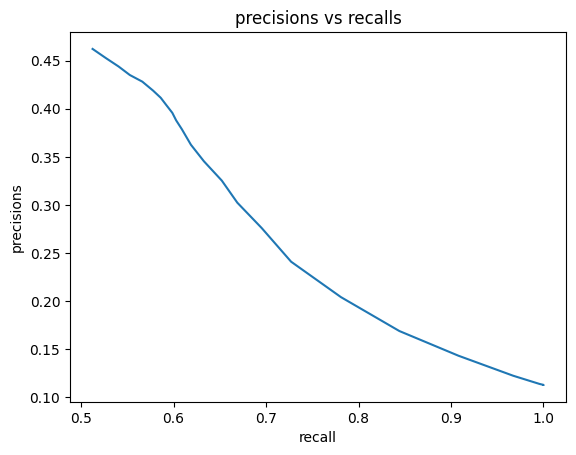

In [506]:
plt.plot(recalls, precisions)
plt.title('precisions vs recalls')
plt.xlabel('recall')
plt.ylabel('precisions')

In [507]:
rec = np.array(recalls)
pre = np.array(precisions)

r = (rec - np.min(rec)) / (np.max(rec) - np.min(rec))
p = (pre - np.min(pre)) / (np.max(pre) - np.min(pre))

auc(r, p)

0.39893988515435963

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ мороженку и бананы